In [4]:
import argparse
import sys
import tempfile
import pickle
import numpy as np
import cv2
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

NO_OF_CLASSES = 43

## Utils

### Load data

In [2]:
def load_data():
  # Load pickled data
  training_file = 'data/train.p'
  validation_file= 'data/valid.p'
  testing_file = 'data/test.p'

  with open(training_file, mode='rb') as f:
      train = pickle.load(f)
  with open(validation_file, mode='rb') as f:
      valid = pickle.load(f)
  with open(testing_file, mode='rb') as f:
      test = pickle.load(f)
      
  x_train, y_train = train['features'], train['labels']
  x_valid, y_valid = valid['features'], valid['labels']
  x_test, y_test = test['features'], test['labels']

  return x_train, y_train, x_valid, y_valid, x_test, y_test

### Preprocessing

In [21]:
def flatten(image):
    return image.flatten()


def normalize_im(image):
    mini, maxi = np.min(image), np.max(image)
    return (image - mini) / (maxi - mini) * 2 - 1


def preprocess_im(image):
    image = cv2.resize(image, (28, 28)) # Resize image
    image = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))[0] # Convert image to grayscale
    image = cv2.equalizeHist(image) # Equalize image
    image = normalize_im(image)
    return np.expand_dims(image, axis=2)


def preprocess(dataset):
    return np.array([preprocess_im(im) for im in dataset])

### Model

In [5]:
def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.

  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.

  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, NO_OF_CLASSES])
    b_fc2 = bias_variable([NO_OF_CLASSES])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

## Data Exploratory

#### Load training, validation, and test data

In [7]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data()

x_train_n = preprocess(x_train)
x_valid_n = preprocess(x_valid)
x_test_n = preprocess(x_test)

#### Load labels

In [10]:
signnames = pd.read_csv('labels.csv')['SignName']

#### Data summary

In [12]:
n_train = y_train.size
n_valid = y_valid.size
n_test = y_test.size
image_shape = x_train.shape[1:]

print("Number of training examples", n_train)
print("Number of validation examples", n_valid)
print("Number of testing examples", n_test)
print("Image data shape", image_shape)
print("Number of classes", NO_OF_CLASSES)

Number of training examples 34799
Number of validation examples 4410
Number of testing examples 12630
Image data shape (32, 32, 3)
Number of classes 43


#### Data visualization

##### **Raw data**

Speed limit (20km/h)


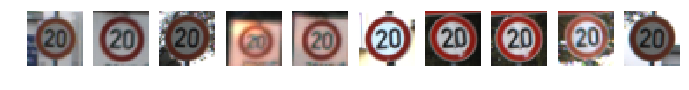

Speed limit (30km/h)


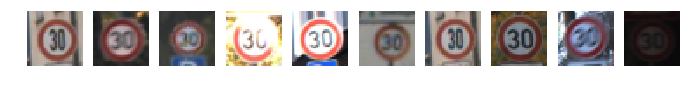

Speed limit (50km/h)


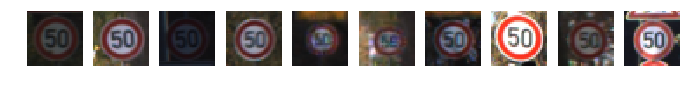

Speed limit (60km/h)


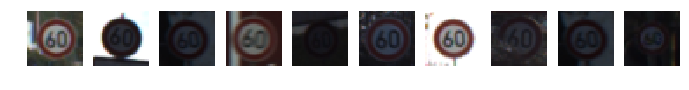

Speed limit (70km/h)


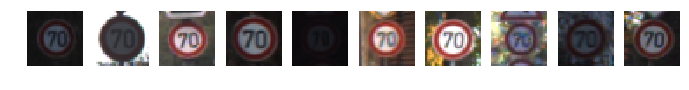

Speed limit (80km/h)


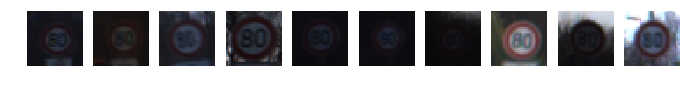

End of speed limit (80km/h)


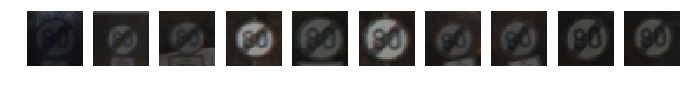

Speed limit (100km/h)


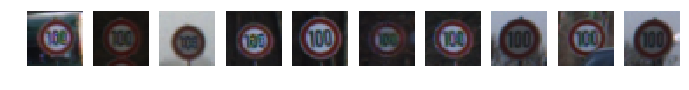

Speed limit (120km/h)


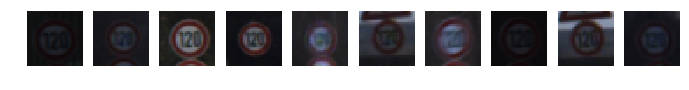

No passing


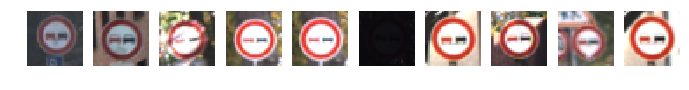

No passing for vehicles over 3.5 metric tons


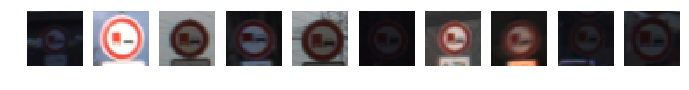

Right-of-way at the next intersection


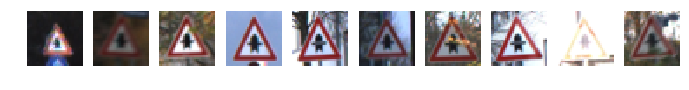

Priority road


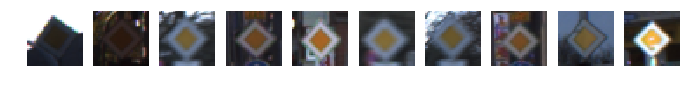

Yield


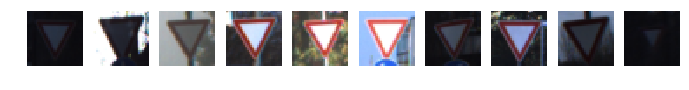

Stop


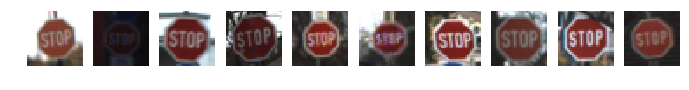

No vehicles


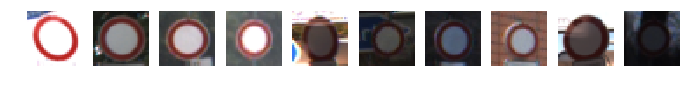

Vehicles over 3.5 metric tons prohibited


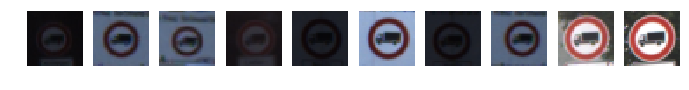

No entry


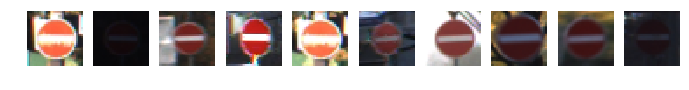

General caution


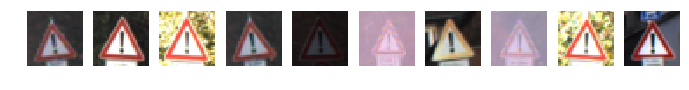

Dangerous curve to the left


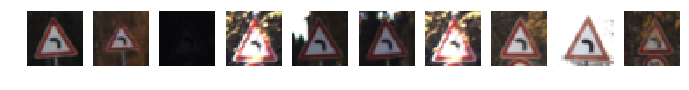

Dangerous curve to the right


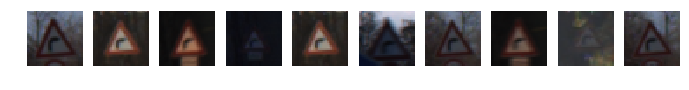

Double curve


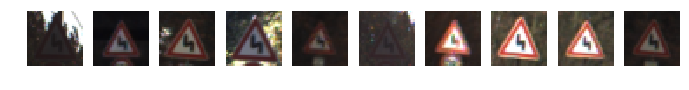

Bumpy road


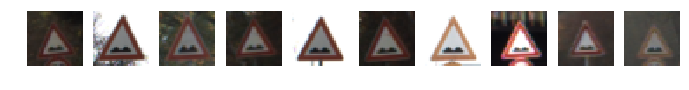

Slippery road


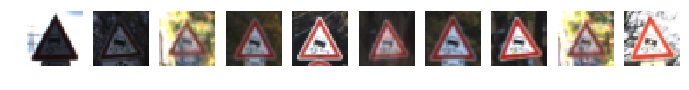

Road narrows on the right


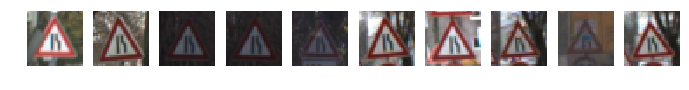

Road work


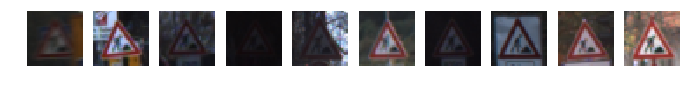

Traffic signals


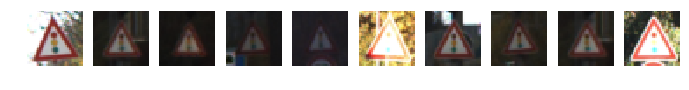

Pedestrians


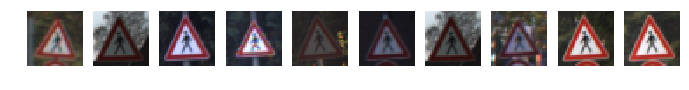

Children crossing


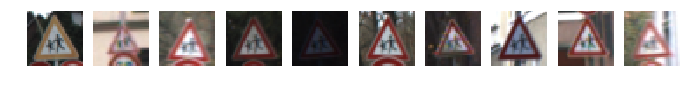

Bicycles crossing


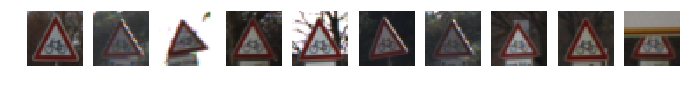

Beware of ice/snow


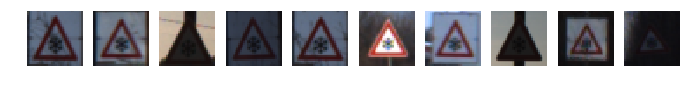

Wild animals crossing


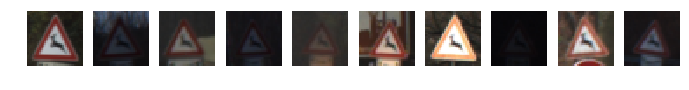

End of all speed and passing limits


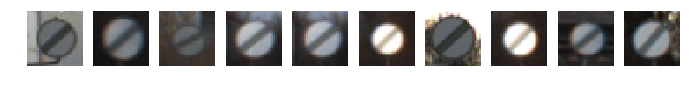

Turn right ahead


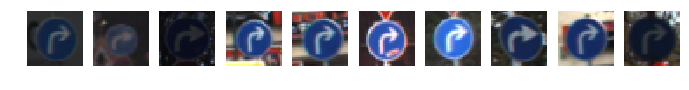

Turn left ahead


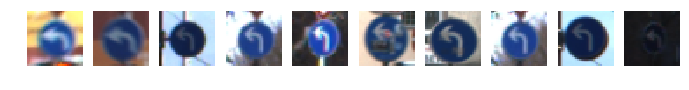

Ahead only


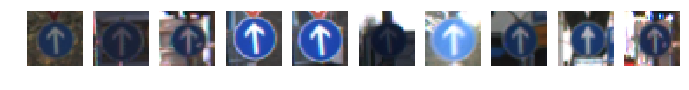

Go straight or right


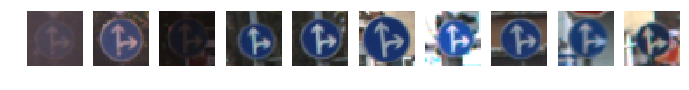

Go straight or left


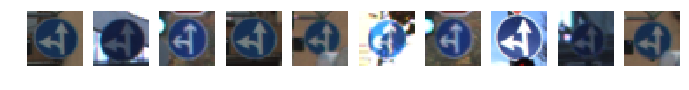

Keep right


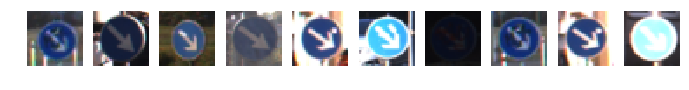

Keep left


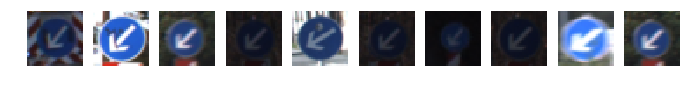

Roundabout mandatory


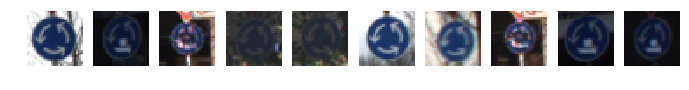

End of no passing


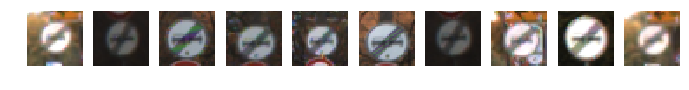

End of no passing by vehicles over 3.5 metric tons


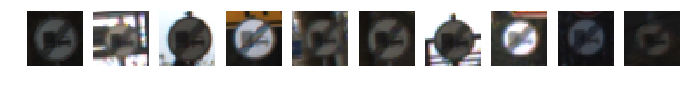

In [16]:
n = 10  # Examples to display
A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

for c in range(NO_OF_CLASSES):  # Iterate all classes
    idx = np.where(y_train == c)  # Find index for class
    n_images = x_train[np.random.choice(idx[0], n)]  # Pick n random images to display
    f, axes = plt.subplots(1, n)
    f.set_size_inches(A4_LANDSCAPE)
    print(signnames[c])
    for i, image in enumerate(n_images):
        axes[i].imshow(image)
        axes[i].grid(False)
        axes[i].axis('off')
    plt.show()

##### **Data distribution**

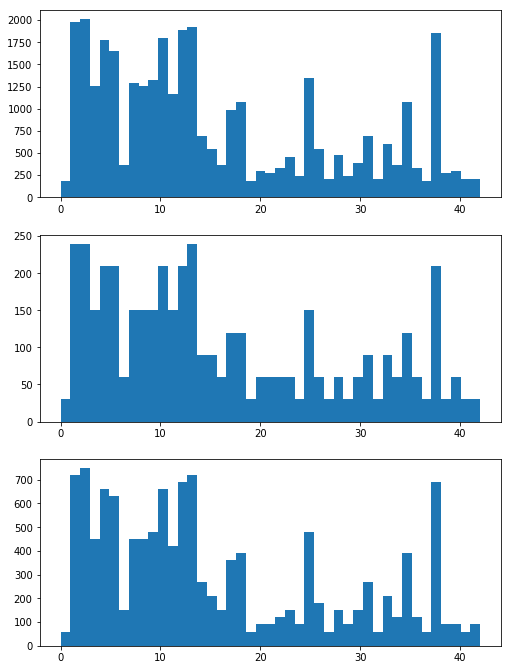

In [19]:
f, axes = plt.subplots(3, 1)
f.set_size_inches(A4_PORTRAIT)
for i, dataset in enumerate([y_train, y_valid, y_test]):
    axes[i].hist(dataset, bins=NO_OF_CLASSES)

##### **Sample of preprocessed data**

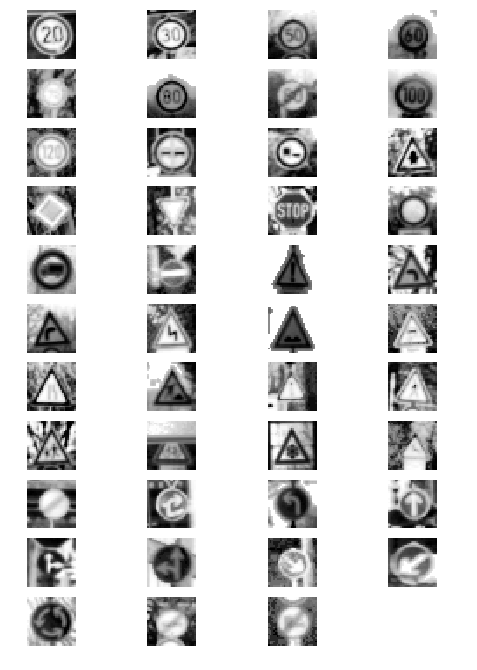

In [18]:
f, axes = plt.subplots(11, 4)
f.set_size_inches(A4_PORTRAIT)
c = 0
for row in axes:
    for ax in row:
        if c < n_classes:
            im = (x_train_n[np.random.choice(np.where(y_train == c)[0], 1)] + 1) / 2
            ax.imshow(im[0,:,:,0], cmap='gray')
        ax.grid(False)
        ax.axis('off')
        c += 1
plt.show()

##### **Data Augmentation**

For a more robust model I have decided to augment the training dataset. This was also used to rebalance the number of examples for each class to eliminate biases in the final model.

In [20]:
def rotate(image, angle=15):
    angle = np.random.randint(-angle, angle)
    M = cv2.getRotationMatrix2D((14, 14), angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(28, 28))


def translate(image, pixels=2):
    tx = np.random.choice(range(-pixels, pixels))
    ty = np.random.choice(range(-pixels, pixels))
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(src=image, M=M, dsize=(28, 28))


def random_bright(image):
    eff = 0.5 + np.random.random()
    return image * eff

def generate(images, count):
    generated = []
    while True:
        for image in images:
            if len(generated) == count:
                return generated
            image = random_bright(image)
            image = rotate(image)
            image = translate(image)
            image = normalize_im(image)
            generated.append(np.expand_dims(image, axis=2))
            

unique, counts = np.unique(y_train, return_counts=True)

target = 5000
x_augmented = []
y_augmented = []

for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'):
    diff = target - count
    x_augmented += generate(x_train_n[np.where(y_train == cls)[0]], diff)
    y_augmented += [cls for _ in range(diff)]

x_train_n = np.concatenate([x_train_n, np.array(x_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])
n_train = y_train.size
print('Final number of training examples', n_train)

Augmenting training dataset: 100%|██████████| 43/43 [00:14<00:00,  2.69it/s]


Final number of training examples 215000


# Model Building

In [22]:
# Create the model
x = tf.placeholder(tf.float32, [None, 784], name='input')

# Define loss and optimizer
y_ = tf.placeholder(tf.int32, [None])
one_hot_y = tf.one_hot(y_, n_classes)

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,
                                                        logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

global_step = tf.Variable(0, name='global_step', trainable=False)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy, global_step=global_step)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(one_hot_y, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

saver = tf.train.Saver()

Saving graph to: /tmp/tmpkc_ir8tv


### Data generator

In [23]:
def generator(x_data, y_data, batch_size, shuffle=False, desc=None):
    if shuffle:
        x_data, y_data = sklearn.utils.shuffle(x_data, y_data)
    gen = range(0, len(x_data), batch_size)
    gen = tqdm(gen, desc) if desc is not None else gen
    for offset in gen:
        end = offset + batch_size
        yield x_data[offset:end], y_data[offset:end]

 ### Prepare data for training

In [24]:
x_train_flatten = np.array([flatten(im) for im in x_train_n])
x_valid_flatten = np.array([flatten(im) for im in x_valid_n])
x_test_flatten = np.array([flatten(im) for im in x_test_n])

### Model training

In [25]:
EPOCHS = 50
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCHS):
        desc = "EPOCH {} ...".format(i + 1)
        for x_batch, y_batch in generator(x_train_flatten, y_train, batch_size=32, shuffle=True, desc=desc):
            sess.run(train_step, feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
            
        print('test accuracy %g' % accuracy.eval(feed_dict={
        x: x_valid_flatten, y_: y_valid, keep_prob: 1.0}))
        
        graph_location = "."
        save_path = saver.save(sess, graph_location + "/output/traffic_net", global_step=i)

EPOCH 1 ...: 100%|██████████| 6719/6719 [06:57<00:00, 16.40it/s]


test accuracy 0.771882


EPOCH 2 ...: 100%|██████████| 6719/6719 [06:59<00:00, 16.03it/s]


test accuracy 0.859184


EPOCH 3 ...: 100%|██████████| 6719/6719 [07:05<00:00, 15.79it/s]


test accuracy 0.889796


EPOCH 4 ...: 100%|██████████| 6719/6719 [07:07<00:00, 16.17it/s]


test accuracy 0.919955


EPOCH 5 ...: 100%|██████████| 6719/6719 [07:11<00:00, 15.56it/s]


test accuracy 0.930159


EPOCH 6 ...: 100%|██████████| 6719/6719 [07:25<00:00, 15.09it/s]


test accuracy 0.940136


EPOCH 7 ...: 100%|██████████| 6719/6719 [07:16<00:00, 15.38it/s]


test accuracy 0.939002


EPOCH 8 ...:  76%|███████▌  | 5077/6719 [05:33<01:47, 15.27it/s]

KeyboardInterrupt: 

EPOCH 8 ...:  76%|███████▌  | 5077/6719 [05:50<01:47, 15.27it/s]